In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import logging
import warnings
warnings.filterwarnings('ignore')

from inspect import signature
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, KFold
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, explained_variance_score, mean_squared_error, r2_score, max_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler, MaxAbsScaler
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.base import BaseEstimator, RegressorMixin, clone, is_classifier, is_regressor
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, PowerTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

In [2]:
class ZeroInflatedRegressor(BaseEstimator, RegressorMixin):
    """A meta regressor for zero-inflated datasets, i.e. the targets contain a lot of zeroes.

    `ZeroInflatedRegressor` consists of a classifier and a regressor.

        - The classifier's task is to find if the target is zero or not.
        - The regressor's task is to output a (usually positive) prediction whenever the classifier indicates that the
        there should be a non-zero prediction.

    The regressor is only trained on examples where the target is non-zero, which makes it easier for it to focus.

    At prediction time, the classifier is first asked if the output should be zero. If yes, output zero.
    Otherwise, ask the regressor for its prediction and output it.

    Parameters
    ----------
    classifier : scikit-learn compatible classifier
        A classifier that answers the question "Should the output be zero?".
    regressor : scikit-learn compatible regressor
        A regressor for predicting the target. Its prediction is only used if `classifier` says that the output is
        non-zero.

    Attributes
    ----------
    classifier_ : scikit-learn compatible classifier
        The fitted classifier.
    regressor_ : scikit-learn compatible regressor
        The fitted regressor."""

    def __init__(self, classifier, regressor) -> None:
        self.classifier = classifier
        self.regressor = regressor

    def fit(self, X, y, sample_weight=None):
        """Fit the underlying classifier and regressor using `X` and `y` as training data. The regressor is only trained
        on examples where the target is non-zero.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The training data.
        y : array-like of shape (n_samples,)
            The target values.
        sample_weight : array-like of shape (n_samples,), default=None
            Individual weights for each sample.

        Returns
        -------
        self : ZeroInflatedRegressor
            The fitted estimator.

        Raises
        ------
        ValueError
            If `classifier` is not a classifier or `regressor` is not a regressor.
        """
        X, y = check_X_y(X, y)
        self._check_n_features(X, reset=True)
        if not is_classifier(self.classifier):
            raise ValueError(
                f"`classifier` has to be a classifier. Received instance of {type(self.classifier)} instead."
            )
        if not is_regressor(self.regressor):
            raise ValueError(f"`regressor` has to be a regressor. Received instance of {type(self.regressor)} instead.")

        try:
            check_is_fitted(self.classifier)
            self.classifier_ = self.classifier
        except NotFittedError:
            self.classifier_ = clone(self.classifier)

            if "sample_weight" in signature(self.classifier_.fit).parameters:
                self.classifier_.fit(X, y != 0, sample_weight=sample_weight)
            else:
                logging.warning("Classifier ignores sample_weight.")
                self.classifier_.fit(X, y != 0)

        non_zero_indices = np.where(self.classifier_.predict(X) == 1)[0]

        if non_zero_indices.size > 0:
            try:
                check_is_fitted(self.regressor)
                self.regressor_ = self.regressor
            except NotFittedError:
                self.regressor_ = clone(self.regressor)

                if "sample_weight" in signature(self.regressor_.fit).parameters:
                    self.regressor_.fit(
                        X[non_zero_indices],
                        y[non_zero_indices],
                        sample_weight=sample_weight[non_zero_indices] if sample_weight is not None else None,
                    )
                else:
                    logging.warning("Regressor ignores sample_weight.")
                    self.regressor_.fit(
                        X[non_zero_indices],
                        y[non_zero_indices],
                    )
        else:
            raise ValueError(
                """The predicted training labels are all zero, making the regressor obsolete. Change the classifier
                or use a plain regressor instead."""
            )

        return self

    def predict(self, X):
        """Predict target values for `X` using fitted estimator by first asking the classifier if the output should be
        zero. If yes, output zero. Otherwise, ask the regressor for its prediction and output it.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The data to predict.

        Returns
        -------
        array-like of shape (n_samples,)
            The predicted values.
        """
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)

        output = np.zeros(len(X))
        non_zero_indices = np.where(self.classifier_.predict(X))[0]

        if non_zero_indices.size > 0:
            output[non_zero_indices] = self.regressor_.predict(X[non_zero_indices])

        return output

In [3]:
def runner(scaler, model, X_train, y_train, X_test):
    scaler.fit(X_train)
    Xt_train = scaler.transform(X_train)
    Xt_test = scaler.transform(X_test)

    model.fit(Xt_train, y_train)
    preds = model.predict(Xt_test)
    return preds

def sc_tester(model, X_train, y_train, X_test, y_test):      
    scalers = [StandardScaler(), MinMaxScaler(), PowerTransformer(), RobustScaler(), MaxAbsScaler()]
    results = []

    for scaler in scalers:
        preds = runner(scaler, model, X_train, y_train, X_test)

        f1 = f1_score(y_test, preds, average="weighted")
        accuracy = accuracy_score(y_test, preds)
        precision = precision_score(y_test, preds, average="weighted")
        recall = recall_score(y_test, preds, average="weighted")
        mcc = matthews_corrcoef(y_test, preds)

        result_dict = {
            'Scaler': str(scaler),
            'Model': str(model),
            'F1 Score': f1,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'MCC': mcc
        }

        results.append(result_dict)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by=['MCC'], ascending=False)
    return results_df

In [4]:
#REGRESSION FUNCTIONS
def regression_plot(y_test_reg, y_predict, X_test):
    
    fig = plt.figure(figsize=(10,5))
    plt.scatter(y_test_reg, y_predict, color='blue', alpha=0.2)
    plt.xlabel("Prediction values")
    plt.ylabel("Truth values")
    plt.plot([min(y_test_reg),max(y_test_reg)], [min(y_test_reg),max(y_test_reg)], linestyle="-", lw=1, color="k")
    plt.show()

def regression_evaluation_df(truth, preds):
    
    rve = explained_variance_score(truth, preds)
    rmse = mean_squared_error(truth, preds, squared=False)
    corr, pval = pearsonr(truth, preds)
    max_err = max_error(truth, preds)
    mae = mean_absolute_error(truth, preds)

    results = {'Test RVE': [rve], 'Test RMSE': [rmse], 'Test R^2': [corr], 'R^2 p-value': [pval], 
               'Test Maximum Error': [max_err], 'Test MAE': [mae]} 
    results_df = pd.DataFrame(results)
    
    return results_df

def regression_scores(regression_name, regressor, X_train, y_train, parameters=None, metric="neg_mean_absolute_error"):
    
    if parameters == None:
        
        kf = KFold(n_splits=5, shuffle=True)
        kf.get_n_splits(X_train)
        rve_scores, rmse_scores, r2_scores, max_error_scores, mae_scores = [], [], [], [], []
        
        X_train, y_train = np.array(X_train), np.array(y_train)
        
        for train_index, test_index in kf.split(X_train):
            
            X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

            regressor.fit(X_train_fold, y_train_fold)
            preds = regressor.predict(X_test_fold)

            rve_scores.append(explained_variance_score(y_test_fold, preds))
            rmse_scores.append(mean_squared_error(y_test_fold, preds, squared=False))
            r2_scores.append(r2_score(y_test_fold, preds))
            max_error_scores.append(max_error(y_test_fold, preds))
            mae_scores.append(mean_absolute_error(y_test_fold, preds))

        eval_dict = {'Model' : [regression_name], 'CV RVE': [np.mean(rve_scores)], 'CV RMSE': [np.mean(rmse_scores)],
                     'CV R^2': [np.mean(r2_scores)], 'CV Maximum Error': [np.mean(max_error_scores)], 'CV MAE': [np.mean(mae_scores)]}
        eval_df = pd.DataFrame(eval_dict)
        
        return eval_df
    
    else:
        
        gs = GridSearchCV(regressor, parameters, cv=5, scoring=metric)
        gs.fit(X_train, y_train)

        best_params, best_score = gs.best_params_, gs.best_score_
        
        dict_scorers = {'rve': 'explained_variance', 'rmse': 'neg_mean_squared_error', 'r2': 'r2',
                        'maximum_error': 'max_error', 'mae': 'neg_mean_absolute_error'}
        
        scores = cross_validate(gs, X_train, y_train, cv=5, scoring=dict_scorers, n_jobs=-1)
        
        eval_dict = {'Model': [regression_name], 'CV RVE': [np.mean(scores['test_rve'])], 'CV RMSE': [np.mean(np.sqrt(np.abs(scores['test_rmse'])))],
                     'CV R^2': [np.mean(scores['test_r2'])], 'CV Maximum Error': [np.mean(scores['test_maximum_error'])], 'CV MAE': [np.mean(scores['test_mae'])]}
        eval_df = pd.DataFrame(eval_dict)
        
        return gs.best_estimator_, eval_df, best_params

In [5]:
def classification_evaluation(y_test_clf, predictions):

    accuracy = accuracy_score(y_test_clf, predictions)
    precision = precision_score(y_test_clf, predictions)
    recall = recall_score(y_test_clf, predictions)
    f1 = f1_score(y_test_clf, predictions)
    mcc = matthews_corrcoef(y_test_clf, predictions)

    results = {'Test Accuracy': [accuracy], 'Test Precision': [precision], 'Test Recall': [recall], 'Test F1': [f1], 'Test MCC': [mcc]} 
    results_df = pd.DataFrame(results)
    
    return results_df

def classification_model_evaluation(X_train, X_test, y_train, y_test, classifiers):
    results_list = []
    for name, (classifier, param_grid) in classifiers.items():
        clf = classifier()
        grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1_micro', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        
        predictions = best_model.predict(X_test)
        results = classification_evaluation(y_test, predictions)
        results_dict = {'Classifier': name, 'Best Params': best_params}
        results_dict.update(results.iloc[0].to_dict())  # Add evaluation metrics to the results_dict
        results_list.append(results_dict)
    
    results_df = pd.DataFrame(results_list)
    return results_df


classifier_params = {
    'Logistic Regression': (LogisticRegression, {'C': [0.001, 0.01, 0.1, 1.0, 10.0], 'max_iter': [1000]}),
    'SVM': (SVC, {'C': [0.001, 0.01, 0.1, 1.0], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}),
    'Decision Tree': (DecisionTreeClassifier, {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}),
    'Random Forest': (RandomForestClassifier, {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}),
    'LightGBM': (LGBMClassifier, {'n_estimators': [50, 100, 200,500,600], 'num_leaves': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0]}),
}

## Data preprocessing

In [6]:
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))

In [7]:
X_train = pd.DataFrame(X_train, columns=col_names)
y_train = pd.DataFrame(y_train, columns=['target'])

In [8]:
y_train_class = y_train.copy()
y_train_class['Target'] = y_train_class['target'].apply(lambda x: 1 if x == 0 else 0)
y_train_class = y_train_class.astype('category')
y_train_class = y_train_class.drop(columns=['target'])
y_train_class = y_train_class

In [9]:
y_train_class['Target'].value_counts()

0    6130
1    1207
Name: Target, dtype: int64

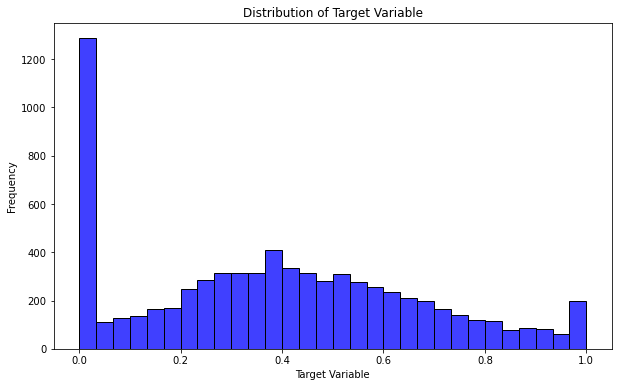

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(y_train.values.flatten(), bins=30, kde=False, color='blue')
plt.title('Distribution of Target Variable')
plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.show()

In [11]:
X_train.columns[X_train.isnull().any()]

Index([], dtype='object')

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7337 entries, 0 to 7336
Columns: 2132 entries, D00 to FP2088
dtypes: float64(2132)
memory usage: 119.3 MB


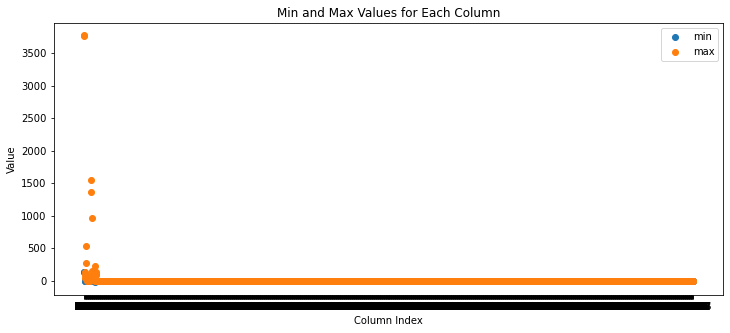

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(X_train.min(axis=0), 'o', label="min") 
plt.plot(X_train.max(axis=0), 'o', label="max")
plt.title('Min and Max Values for Each Column')
plt.legend(loc="best")
plt.xlabel("Column Index")
plt.ylabel("Value")
plt.show()

In [14]:
complete_x = X_train.copy()
complete_y = y_train_class.copy()

X_train_comp, X_test_comp, y_train_comp, y_test_comp = train_test_split(complete_x, complete_y, test_size=0.2, random_state=505)

In [15]:
binary_columns_train = [col for col in X_train.columns if set(X_train[col]) == {0, 1}]  # get the binary columns

binary_x = X_train[binary_columns_train].copy()
binary_y = y_train_class.copy()

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(binary_x, binary_y, test_size=0.2, random_state=505)

In [16]:
float_x = X_train.drop(binary_columns_train, axis=1).copy()
float_y = y_train_class.copy()

X_train_float, X_test_float, y_train_float, y_test_float = train_test_split(float_x, float_y, test_size=0.2, random_state=505)

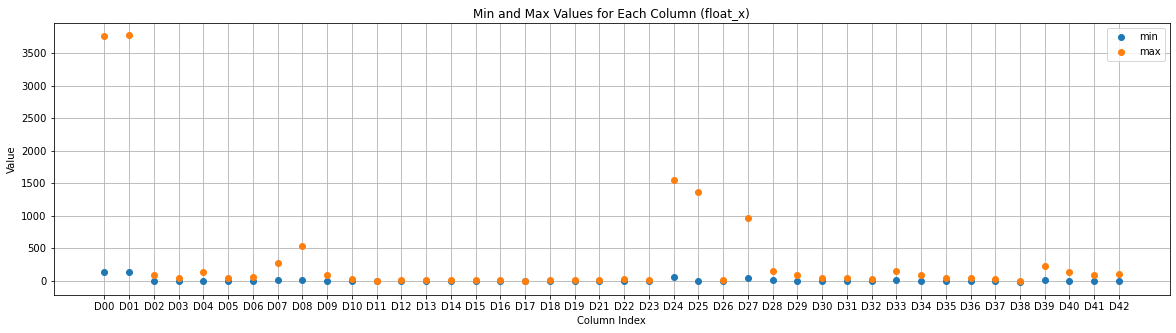

In [17]:
data = float_x
plt.figure(figsize=(20, 5))
plt.plot(data.min(axis=0), 'o', label="min") 
plt.plot(data.max(axis=0), 'o', label="max")
plt.legend(loc="best")
plt.grid()
plt.title("Min and Max Values for Each Column (float_x)")
plt.xlabel("Column Index")
plt.ylabel("Value")
plt.show()

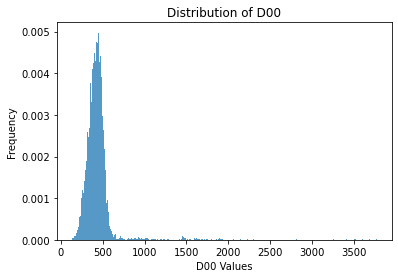

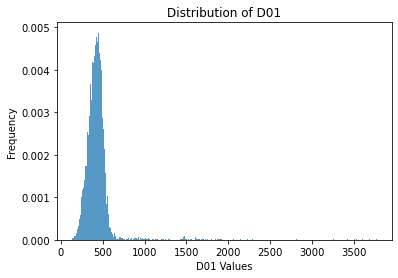

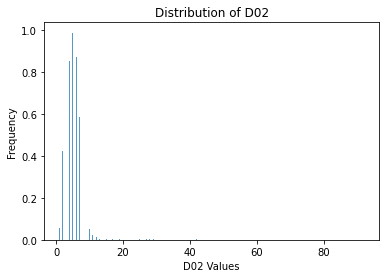

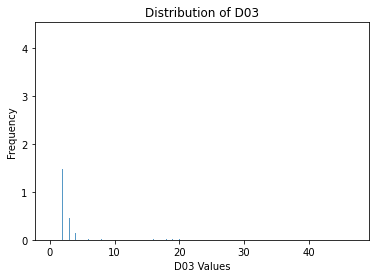

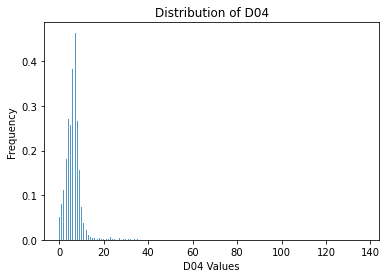

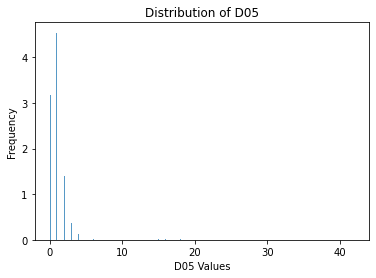

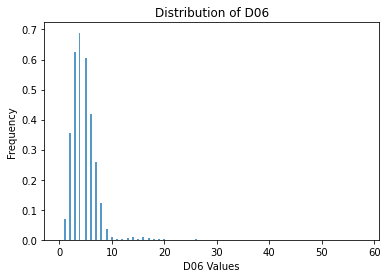

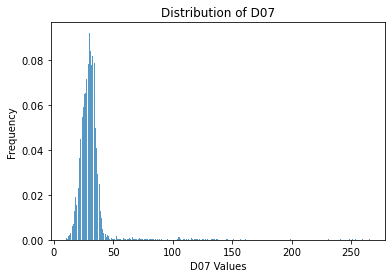

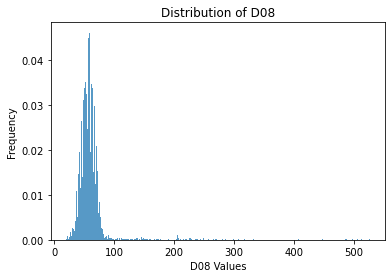

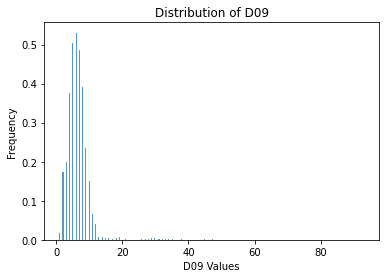

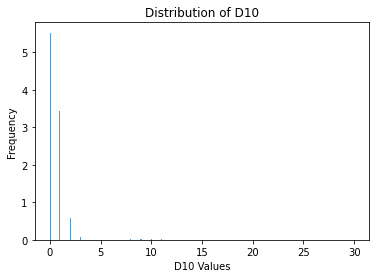

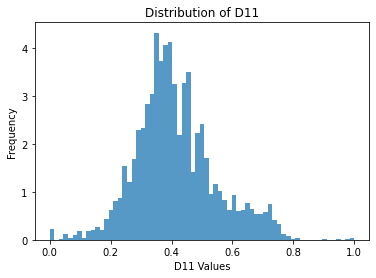

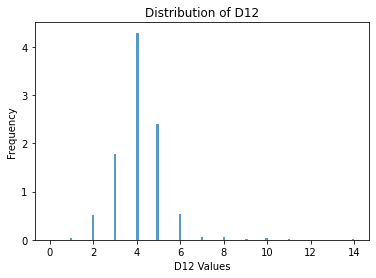

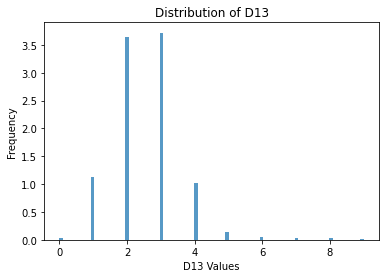

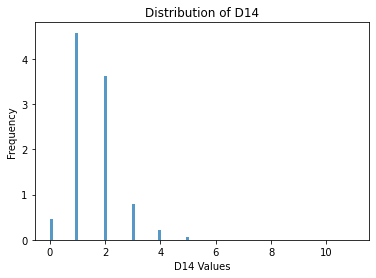

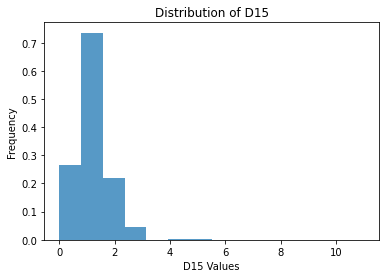

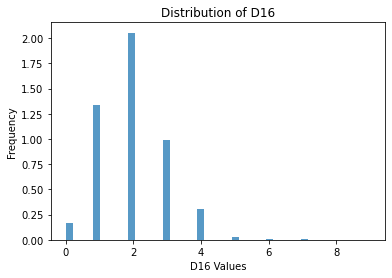

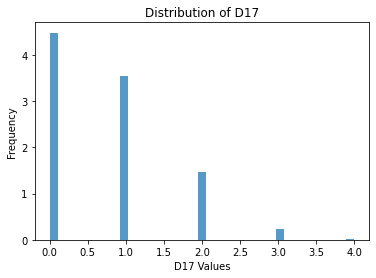

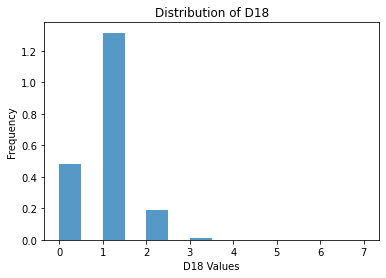

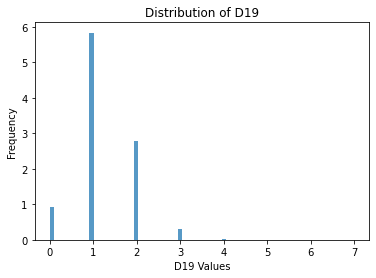

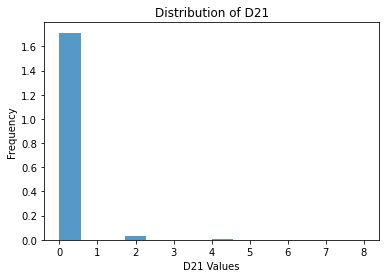

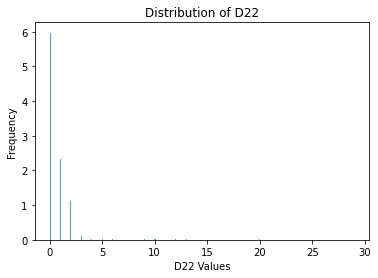

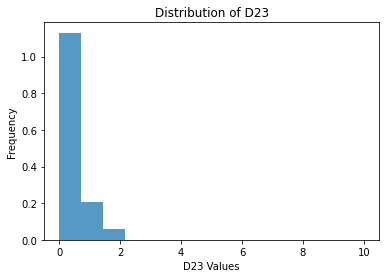

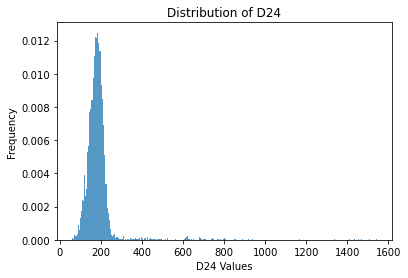

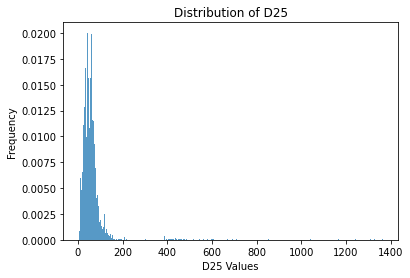

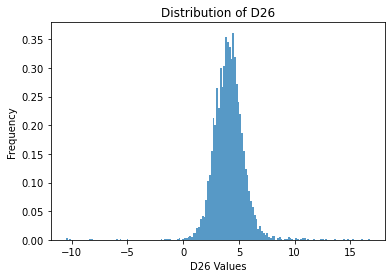

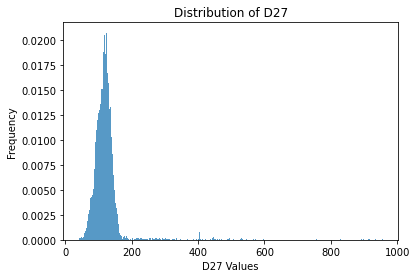

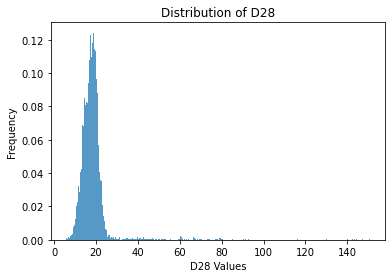

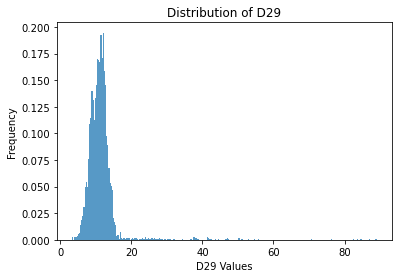

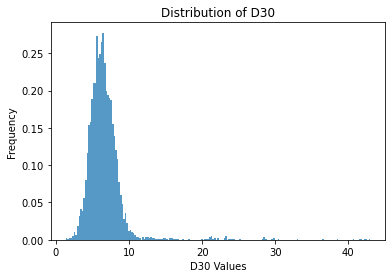

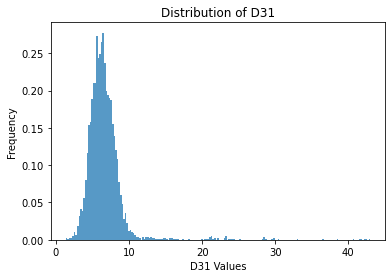

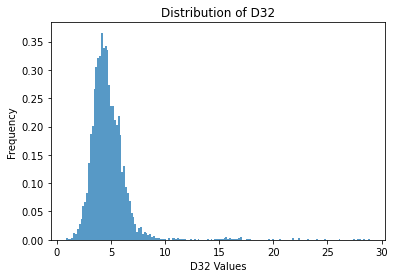

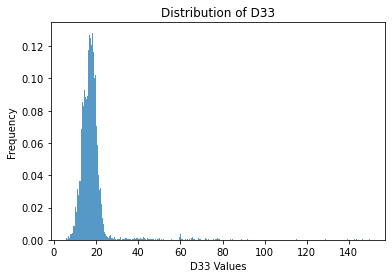

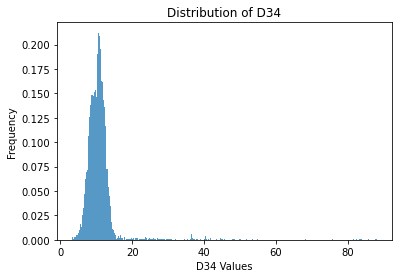

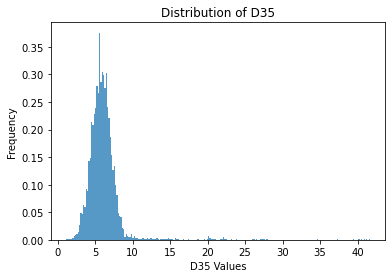

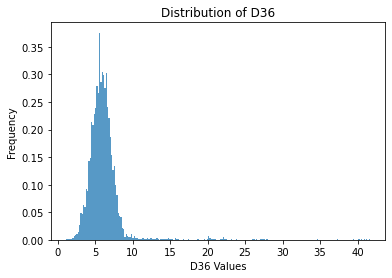

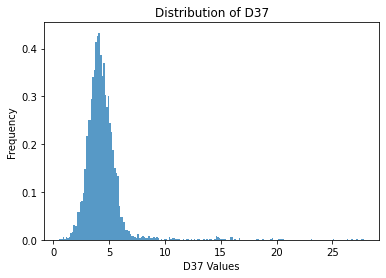

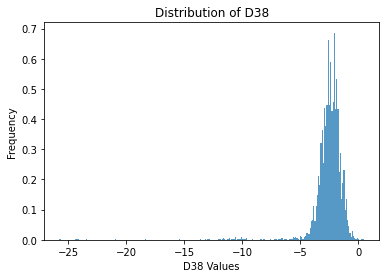

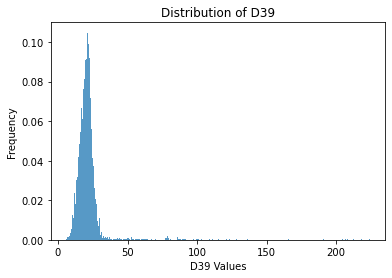

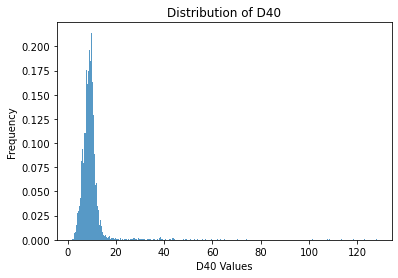

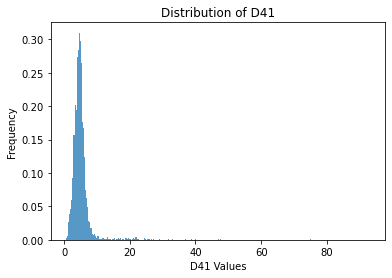

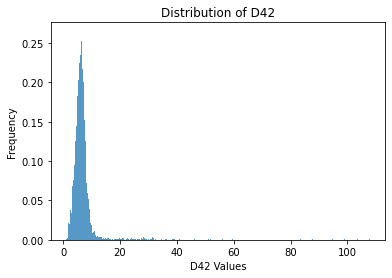

In [18]:
for feature in data.columns:
    plt.hist(data[feature], bins='auto', density=True, alpha=0.75)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(f'{feature} Values')
    plt.ylabel('Frequency')
    plt.show()

In [19]:
results = []
for col in data.columns:
    min_val = data[col].min()
    max_val = data[col].max()
    results.append((col, min_val, max_val))

check = pd.DataFrame(results, columns=['column', 'min', 'max'])
check

,column,min,max
0,D00,135.068414,3768.848446
1,D01,135.166000,3771.262000
2,D02,1.000000,92.000000
3,D03,0.000000,47.000000
4,D04,0.000000,137.000000
5,D05,0.000000,42.000000
6,D06,0.000000,58.000000
7,D07,10.000000,266.000000
8,D08,19.000000,527.000000
9,D09,1.000000,93.000000


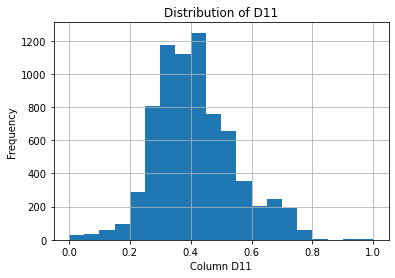

In [20]:
data['D11'].hist(bins=20)
plt.title(f'Distribution of D11')
plt.xlabel('Column D11')
plt.ylabel('Frequency')
plt.show()

In [21]:
rfc_scaler = sc_tester(RandomForestClassifier(), X_train_float, y_train_float, X_test_float, y_test_float)
rfc_scaler

,Scaler,Model,F1 Score,Accuracy,Precision,Recall,MCC
0,StandardScaler(),RandomForestClassifier(),0.841087,0.859673,0.843842,0.859673,0.427811
3,RobustScaler(),RandomForestClassifier(),0.841087,0.859673,0.843842,0.859673,0.427811
2,PowerTransformer(),RandomForestClassifier(),0.840382,0.858311,0.841951,0.858311,0.424059
4,MaxAbsScaler(),RandomForestClassifier(),0.837570,0.856948,0.839991,0.856948,0.414079
1,MinMaxScaler(),RandomForestClassifier(),0.834362,0.853542,0.835234,0.853542,0.400450


In [22]:
lg_scaler = sc_tester(LogisticRegression(max_iter=10000), X_train_float, y_train_float, X_test_float, y_test_float)
lg_scaler

,Scaler,Model,F1 Score,Accuracy,Precision,Recall,MCC
3,RobustScaler(),LogisticRegression(max_iter=10000),0.770735,0.833106,0.817953,0.833106,0.187774
0,StandardScaler(),LogisticRegression(max_iter=10000),0.768214,0.832425,0.818991,0.832425,0.178286
2,PowerTransformer(),LogisticRegression(max_iter=10000),0.773059,0.830381,0.794852,0.830381,0.175299
1,MinMaxScaler(),LogisticRegression(max_iter=10000),0.751625,0.827657,0.857420,0.827657,0.098463
4,MaxAbsScaler(),LogisticRegression(max_iter=10000),0.751625,0.827657,0.857420,0.827657,0.098463


In [23]:
dt_scaler = sc_tester(DecisionTreeClassifier(), X_train_float, y_train_float, X_test_float, y_test_float)
dt_scaler

,Scaler,Model,F1 Score,Accuracy,Precision,Recall,MCC
0,StandardScaler(),DecisionTreeClassifier(),0.817073,0.818801,0.815475,0.818801,0.359031
2,PowerTransformer(),DecisionTreeClassifier(),0.817073,0.818801,0.815475,0.818801,0.359031
3,RobustScaler(),DecisionTreeClassifier(),0.813785,0.815395,0.812283,0.815395,0.347975
1,MinMaxScaler(),DecisionTreeClassifier(),0.813483,0.815395,0.811721,0.815395,0.345973
4,MaxAbsScaler(),DecisionTreeClassifier(),0.811876,0.813351,0.810488,0.813351,0.341764


In [24]:
svc_scaler = sc_tester(SVC(), X_train_float, y_train_float, X_test_float, y_test_float)
svc_scaler

,Scaler,Model,F1 Score,Accuracy,Precision,Recall,MCC
2,PowerTransformer(),SVC(),0.799953,0.846730,0.844238,0.846730,0.314133
0,StandardScaler(),SVC(),0.784417,0.840599,0.844696,0.840599,0.263522
4,MaxAbsScaler(),SVC(),0.765328,0.833106,0.848132,0.833106,0.186508
1,MinMaxScaler(),SVC(),0.746749,0.825613,0.681637,0.825613,0.000000
3,RobustScaler(),SVC(),0.746749,0.825613,0.681637,0.825613,0.000000


In [25]:
lgbm_scaler = sc_tester(LGBMClassifier(), X_train_float, y_train_float, X_test_float, y_test_float)
lgbm_scaler

[LightGBM] [Info] Number of positive: 951, number of negative: 4918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6039
[LightGBM] [Info] Number of data points in the train set: 5869, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.162038 -> initscore=-1.643143
[LightGBM] [Info] Start training from score -1.643143
[LightGBM] [Info] Number of positive: 951, number of negative: 4918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6002
[LightGBM] [Info] Number of data points in the train set: 5869, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.162038 -> initscore=-1.643143
[LightGBM] [Info] Start training from score -1.643143
[LightGBM] [Info] Nu

,Scaler,Model,F1 Score,Accuracy,Precision,Recall,MCC
2,PowerTransformer(),LGBMClassifier(),0.850117,0.868529,0.856735,0.868529,0.466102
0,StandardScaler(),LGBMClassifier(),0.848971,0.867166,0.854606,0.867166,0.460680
1,MinMaxScaler(),LGBMClassifier(),0.846174,0.865804,0.853142,0.865804,0.451553
3,RobustScaler(),LGBMClassifier(),0.845305,0.863760,0.849686,0.863760,0.445457
4,MaxAbsScaler(),LGBMClassifier(),0.842486,0.862398,0.848050,0.862398,0.435990


In [ ]:
pca.fit_transform(x_train)
pca.transform(x_test)

In [26]:
scaler = PowerTransformer()
X_train_float = scaler.fit_transform(X_train_float)
X_test_float = scaler.transform(X_test_float)

In [27]:
results_float = classification_model_evaluation(X_train_float, X_test_float, y_train_float, y_test_float, classifier_params)
results_float

[LightGBM] [Info] Number of positive: 951, number of negative: 4918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 5869, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.162038 -> initscore=-1.643143
[LightGBM] [Info] Start training from score -1.643143


,Classifier,Best Params,Test Accuracy,Test Precision,Test Recall,Test F1,Test MCC
0,Logistic Regression,"{'C': 10.0, 'max_iter': 1000}",0.828338,0.550000,0.085938,0.148649,0.165677
1,SVM,"{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}",0.846730,0.829787,0.152344,0.257426,0.314133
2,Decision Tree,"{'max_depth': 10, 'min_samples_split': 2}",0.826975,0.508197,0.242188,0.328042,0.264857
3,Random Forest,"{'max_depth': 30, 'n_estimators': 100}",0.859673,0.686567,0.359375,0.471795,0.427811
4,LightGBM,"{'learning_rate': 0.1, 'n_estimators': 600, 'n...",0.861035,0.651163,0.437500,0.523364,0.457753


In [29]:
results_float.iloc[4]["Best Params"]

{'learning_rate': 0.1, 'n_estimators': 600, 'num_leaves': 40}

In [32]:
scaler_float = PowerTransformer()
X_train_float_scaled = scaler_float.fit_transform(X_train_float)
X_test_float_scaled = scaler_float.transform(X_test_float)

sm = SMOTE(random_state=505)
X_train_float_resampled, y_train_float_resampled = sm.fit_resample(X_train_float_scaled, y_train_float)
results_float = classification_model_evaluation(X_train_float_resampled, X_test_float_scaled, y_train_float_resampled, y_test_float, classifier_params)
results_float

#SEM SMOTE
model = LGBMClassifier(learning_rate=0.1, n_estimators=600, num_leaves=40) #best classifier
model.fit(X_train_float_scaled, y_train_float)

preds = model.predict(X_test_float_scaled)
classification_evaluation(y_test_float, preds)

[LightGBM] [Info] Number of positive: 4918, number of negative: 4918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9675
[LightGBM] [Info] Number of data points in the train set: 9836, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 951, number of negative: 4918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5527
[LightGBM] [Info] Number of data points in the train set: 5869, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.162038 -> initscore=-1.643143
[LightGBM] [Info] Start training from score -1.643143


,Test Accuracy,Test Precision,Test Recall,Test F1,Test MCC
0,0.864441,0.674847,0.429688,0.52506,0.466136


In [33]:
#COM SMOTE
model = LGBMClassifier(learning_rate=0.1, n_estimators=600, num_leaves=40)
model.fit(X_train_float_resampled, y_train_float_resampled)

preds = model.predict(X_test_float_scaled)
classification_evaluation(y_test_float, preds)

[LightGBM] [Info] Number of positive: 4918, number of negative: 4918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9675
[LightGBM] [Info] Number of data points in the train set: 9836, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,Test Accuracy,Test Precision,Test Recall,Test F1,Test MCC
0,0.867166,0.663102,0.484375,0.559819,0.492103


In [34]:
pca = PCA(n_components=0.9) #to retain 90% of the original variance
pcomp = pca.fit_transform(X_train_float_resampled)
pca_df = pd.DataFrame(data=pcomp)
pca_df #8 principal components

,0,1,2,3,4,5,6,7
0,-3.482497,2.432890,3.299718,-1.474394,0.261484,0.594351,-0.036051,-2.072727
1,4.928687,4.475373,2.895276,-0.730576,-0.156450,-0.543903,-0.612983,0.537951
2,3.181558,1.389900,0.438418,1.025445,-1.315117,-0.395569,-1.102570,0.017184
3,1.398549,-3.912898,-0.508295,1.841585,0.006868,0.667595,0.773494,1.421601
4,5.292673,-3.834006,2.246000,-1.254803,-0.165056,-0.860873,0.339764,-0.460034
...,...,...,...,...,...,...,...,...
9831,17.346882,-3.235172,2.565327,-3.253459,1.922798,0.270336,0.286889,0.792305
9832,3.427325,-0.548030,-0.974279,-0.678053,-2.167191,0.647185,-0.398127,0.292927
9833,3.598297,-2.545368,2.427634,-2.391761,-1.430634,-0.028163,-0.527120,-0.287208
9834,-0.591117,-0.047658,-1.134994,0.926807,-1.765313,0.018311,0.286387,-0.342450


In [35]:
#using the new principal components as the new training columns
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_df, y_train_float, test_size=0.2, random_state=42)

model = LGBMClassifier(learning_rate=0.1, n_estimators=600, num_leaves=40) #best classifier
model.fit(X_train_pca, y_train_pca)

preds = model.predict(X_test_pca)
classification_evaluation(y_test_pca, preds)

ValueError: Found input variables with inconsistent numbers of samples: [9836, 5869]